# P4 : Segmenter les clients d'un e-commerce : segmentation des données

## Sommaire

* [Importation et format des données](#chapter1)
* [Encodage des variables qualitatives et recherche de corrélation entre les variables quantitatives](#chapter2)
* [Fusion des variables et réduction de dimensions](#chapter3)
* [Segmentation par kmeans avec optimisation du k](#chapter4)
* [Statistiques descriptives des groupes issus de la segmentation par kmeans](#chapter5)
    * [Effectifs](#section_5_1)
    * [Nombre de comptes clients](#section_5_2)
    * [Nombre de commande](#section_5_3)
    * [Montant du panier moyen](#section_5_4)  
    * [Note moyenne attribuée par les clients](#section_5_5)
    * [Morphologie de commentaire la plus fréquemment laissée](#section_5_6)
    * [Moyen de paiement le plus fréquent](#section_5_7)
    * [Comportement de paiement](#section_5_8)
    * [Impact du degrès de détail des annonces produits dans l'intention d'achat](#section_5_9)
    * [Nombre moyen d'objets par commande](#section_5_10)
    * [Impact des frais de livraison dans l'acte d'achat](#section_5_11)
    * [Réactivité commentaire](#section_5_12)
    * [Délais de livraison acceptable](#section_5_13)
    * [Achat local](#section_5_14)

In [1]:
import numpy as np
import pandas as pd
from collections import Counter as count
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from functions import *
import statistics
from sklearn.metrics import adjusted_rand_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

## Importation et format des données <a class="anchor" id="chapter1"></a>

In [2]:
data = pd.read_csv("data.csv", index_col="customer_unique_id")

In [3]:
data.shape

(91492, 13)

In [4]:
data.head()

,nb_customer_id,nb_orders,mean_order_price,review_score_mean,freq_review_comment,freq_payment_type,payment_seq_mean,product_description_details_mean,order_item_id_mean,taux_livrs_mean,react_review_mean,shipping_day_nb_mean,freq_local_seller
customer_unique_id,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,1.0,129.90,5.0,Complet message,credit_card,8.0,141.60,1.0,9.0,1.0,5.0,Yes
0000b849f77a49e4a4ce2b2a4ca5be3f,1,1.0,18.90,4.0,No message,credit_card,1.0,355.60,1.0,44.0,1.0,4.0,Yes
0000f46a3911fa3c0805444483337064,1,1.0,69.00,3.0,No message,credit_card,8.0,260.19,1.0,25.0,1.0,5.0,No
0000f6ccb0745a6a4b88665a16c9f078,1,1.0,25.99,4.0,Message,credit_card,4.0,3743.15,1.0,68.0,1.0,6.0,No
0004aac84e0df4da2b147fca70cf8255,1,1.0,180.00,5.0,No message,credit_card,6.0,1381.56,1.0,9.0,1.0,8.0,Yes


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91492 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nb_customer_id                    91492 non-null  int64  
 1   nb_orders                         91492 non-null  float64
 2   mean_order_price                  91492 non-null  float64
 3   review_score_mean                 91492 non-null  float64
 4   freq_review_comment               91492 non-null  object 
 5   freq_payment_type                 91492 non-null  object 
 6   payment_seq_mean                  91492 non-null  float64
 7   product_description_details_mean  91492 non-null  float64
 8   order_item_id_mean                91492 non-null  float64
 9   taux_livrs_mean                   91492 non-null  float64
 10  react_review_mean                 91492 non-null  float64
 11  shipping_day_n

In [6]:
data.describe()

,nb_customer_id,nb_orders,mean_order_price,review_score_mean,payment_seq_mean,product_description_details_mean,order_item_id_mean,taux_livrs_mean,react_review_mean,shipping_day_nb_mean
count,91492.000000,91492.000000,91492.000000,91492.000000,91492.000000,91492.000000,91492.000000,91492.000000,91492.000000,91492.000000
mean,1.036167,1.237540,137.520862,4.154653,2.970932,985.500793,1.070659,30.890630,0.453464,6.637521
std,0.218633,0.844299,208.615637,1.279189,2.764153,1515.706767,0.265944,31.308329,4.601267,3.658768
min,1.000000,1.000000,0.850000,1.000000,0.000000,1.720000,1.000000,0.000000,-186.000000,2.000000
25%,1.000000,1.000000,46.039107,4.000000,1.000000,231.710000,1.000000,13.000000,1.000000,5.000000
50%,1.000000,1.000000,86.900000,5.000000,2.000000,474.800000,1.000000,23.000000,1.000000,6.000000
75%,1.000000,1.000000,149.900000,5.000000,4.000000,1094.400000,1.000000,38.000000,1.000000,7.000000
max,17.000000,75.000000,13440.000000,5.000000,48.000000,29128.680000,11.000000,2145.000000,67.000000,529.000000


In [7]:
data.isna().mean()

nb_customer_id                      0.0
nb_orders                           0.0
mean_order_price                    0.0
review_score_mean                   0.0
freq_review_comment                 0.0
freq_payment_type                   0.0
payment_seq_mean                    0.0
product_description_details_mean    0.0
order_item_id_mean                  0.0
taux_livrs_mean                     0.0
react_review_mean                   0.0
shipping_day_nb_mean                0.0
freq_local_seller                   0.0
dtype: float64

## Encodage des variables qualitatives et recherche de corrélation entre les variables quantitatives <a class="anchor" id="chapter2"></a>

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91492 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nb_customer_id                    91492 non-null  int64  
 1   nb_orders                         91492 non-null  float64
 2   mean_order_price                  91492 non-null  float64
 3   review_score_mean                 91492 non-null  float64
 4   freq_review_comment               91492 non-null  object 
 5   freq_payment_type                 91492 non-null  object 
 6   payment_seq_mean                  91492 non-null  float64
 7   product_description_details_mean  91492 non-null  float64
 8   order_item_id_mean                91492 non-null  float64
 9   taux_livrs_mean                   91492 non-null  float64
 10  react_review_mean                 91492 non-null  float64
 11  shipping_day_n

In [9]:
data["review_score_mean"] = data["review_score_mean"].astype(int)

In [10]:
data["order_item_id_mean"] = data["order_item_id_mean"].astype(int)

In [11]:
data["react_review_mean"] = data["react_review_mean"].astype(int)

In [12]:
data["shipping_day_nb_mean"] = data["shipping_day_nb_mean"].astype(int)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91492 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nb_customer_id                    91492 non-null  int64  
 1   nb_orders                         91492 non-null  float64
 2   mean_order_price                  91492 non-null  float64
 3   review_score_mean                 91492 non-null  int32  
 4   freq_review_comment               91492 non-null  object 
 5   freq_payment_type                 91492 non-null  object 
 6   payment_seq_mean                  91492 non-null  float64
 7   product_description_details_mean  91492 non-null  float64
 8   order_item_id_mean                91492 non-null  int32  
 9   taux_livrs_mean                   91492 non-null  float64
 10  react_review_mean                 91492 non-null  int32  
 11  shipping_day_n

In [14]:
# Je décompose chaque variable qualitative en sous-catégories que j'encode

comment = pd.get_dummies(data["freq_review_comment"], prefix="Comment")
payment_type = pd.get_dummies(data["freq_payment_type"], prefix="Payment")
local_seller = pd.get_dummies(data["freq_local_seller"], prefix="loc_seller")

In [15]:
data_encod = pd.concat([comment, payment_type, local_seller], axis=1)

In [16]:
data_encod.head()

,Comment_Complet message,Comment_Message,Comment_No message,Comment_Short message,Payment_boleto,Payment_credit_card,Payment_debit_card,Payment_voucher,loc_seller_No,loc_seller_Yes
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,0,0,0,0,1,0,0,0,1
0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,1,0,0,1,0,0,0,1
0000f46a3911fa3c0805444483337064,0,0,1,0,0,1,0,0,1,0
0000f6ccb0745a6a4b88665a16c9f078,0,1,0,0,0,1,0,0,1,0
0004aac84e0df4da2b147fca70cf8255,0,0,1,0,0,1,0,0,0,1


In [17]:
data_encod.shape

(91492, 10)

In [18]:
# Je créé un dataframe sans variables qualitatives
data_qtt = data.drop(
    ["freq_review_comment", "freq_payment_type", "freq_local_seller"], axis=1
)

In [19]:
data_qtt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91492 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nb_customer_id                    91492 non-null  int64  
 1   nb_orders                         91492 non-null  float64
 2   mean_order_price                  91492 non-null  float64
 3   review_score_mean                 91492 non-null  int32  
 4   payment_seq_mean                  91492 non-null  float64
 5   product_description_details_mean  91492 non-null  float64
 6   order_item_id_mean                91492 non-null  int32  
 7   taux_livrs_mean                   91492 non-null  float64
 8   react_review_mean                 91492 non-null  int32  
 9   shipping_day_nb_mean              91492 non-null  int32  
dtypes: float64(5), int32(4), int64(1)
memory usage: 6.3+ MB


<AxesSubplot:>

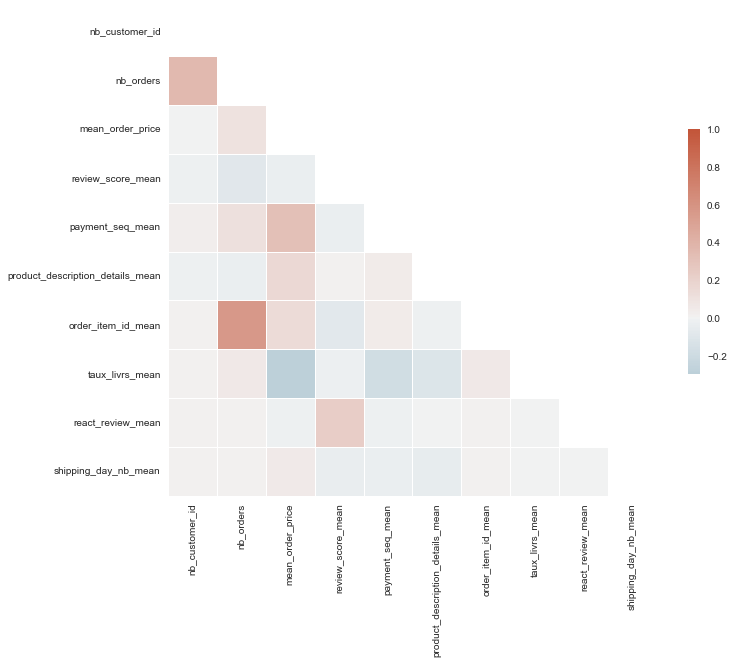

In [20]:
import matplotlib.pyplot as plt

corr = data_qtt.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

In [21]:
var1 = "nb_orders"
var2 = "order_item_id_mean"
print("coefficient de Pearson et covariance pour :", var1, "et", var2)
print(round((st.pearsonr(data_qtt[var1], data_qtt[var2])[0]), 2))
print(round((np.cov(data_qtt[var1], data_qtt[var2], ddof=0)[1, 0]), 2))

coefficient de Pearson et covariance pour : nb_orders et order_item_id_mean
0.57
0.1


In [22]:
var1 = "payment_seq_mean"
var2 = "mean_order_price"
print("coefficient de Pearson et covariance pour :", var1, "et", var2)
print(round((st.pearsonr(data_qtt[var1], data_qtt[var2])[0]), 2))
print(round((np.cov(data_qtt[var1], data_qtt[var2], ddof=0)[1, 0]), 2))

coefficient de Pearson et covariance pour : payment_seq_mean et mean_order_price
0.31
181.29


In [23]:
var1 = "nb_orders"
var2 = "nb_customer_id"
print("coefficient de Pearson et covariance pour :", var1, "et", var2)
print(round((st.pearsonr(data_qtt[var1], data_qtt[var2])[0]), 2))
print(round((np.cov(data_qtt[var1], data_qtt[var2], ddof=0)[1, 0]), 2))

coefficient de Pearson et covariance pour : nb_orders et nb_customer_id
0.36
0.07


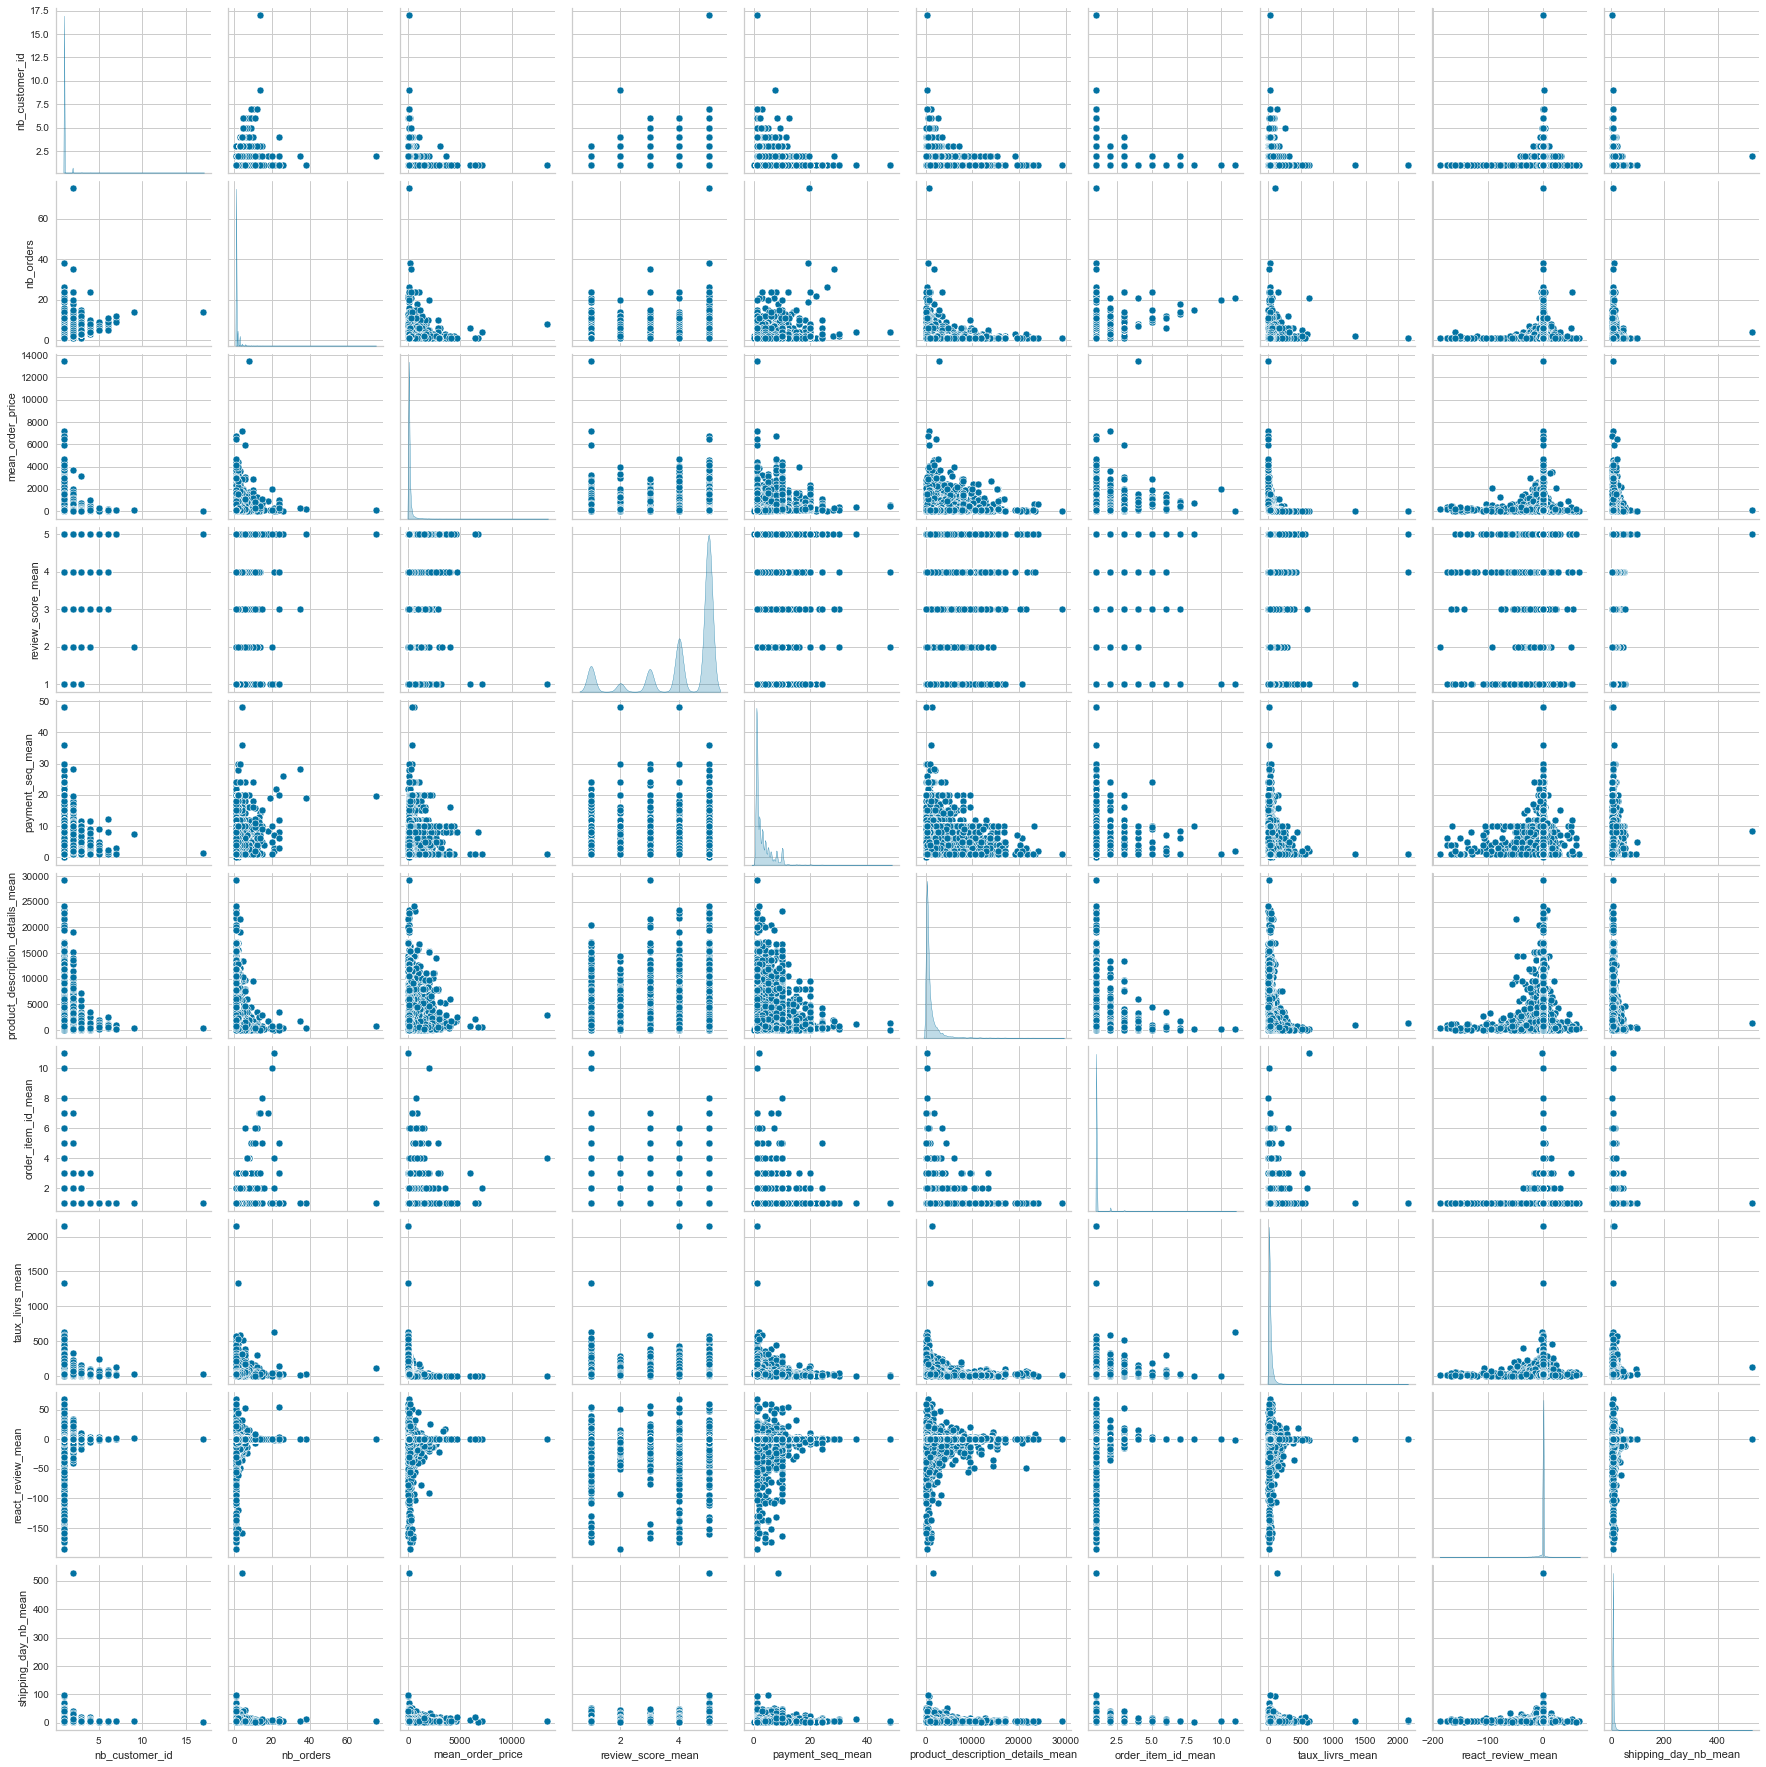

In [88]:
sns.pairplot(data_qtt, diag_kind="kde")

## Fusion des variables et réduction de dimensions <a class="anchor" id="chapter3"></a>

In [24]:
data_all = pd.concat([data_qtt, data_encod], axis=1)

In [25]:
data_all.head()

,nb_customer_id,nb_orders,mean_order_price,review_score_mean,payment_seq_mean,product_description_details_mean,order_item_id_mean,taux_livrs_mean,react_review_mean,shipping_day_nb_mean,Comment_Complet message,Comment_Message,Comment_No message,Comment_Short message,Payment_boleto,Payment_credit_card,Payment_debit_card,Payment_voucher,loc_seller_No,loc_seller_Yes
customer_unique_id,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,1.0,129.90,5,8.0,141.60,1,9.0,1,5,1,0,0,0,0,1,0,0,0,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1,1.0,18.90,4,1.0,355.60,1,44.0,1,4,0,0,1,0,0,1,0,0,0,1
0000f46a3911fa3c0805444483337064,1,1.0,69.00,3,8.0,260.19,1,25.0,1,5,0,0,1,0,0,1,0,0,1,0
0000f6ccb0745a6a4b88665a16c9f078,1,1.0,25.99,4,4.0,3743.15,1,68.0,1,6,0,1,0,0,0,1,0,0,1,0
0004aac84e0df4da2b147fca70cf8255,1,1.0,180.00,5,6.0,1381.56,1,9.0,1,8,0,0,1,0,0,1,0,0,0,1


In [26]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91492 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nb_customer_id                    91492 non-null  int64  
 1   nb_orders                         91492 non-null  float64
 2   mean_order_price                  91492 non-null  float64
 3   review_score_mean                 91492 non-null  int32  
 4   payment_seq_mean                  91492 non-null  float64
 5   product_description_details_mean  91492 non-null  float64
 6   order_item_id_mean                91492 non-null  int32  
 7   taux_livrs_mean                   91492 non-null  float64
 8   react_review_mean                 91492 non-null  int32  
 9   shipping_day_nb_mean              91492 non-null  int32  
 10  Comment_Complet message           91492 non-null  uint8  
 11  Comment_Messag

In [27]:
data_all.shape

(91492, 20)

In [28]:
X = data_all.dropna()
keep_ind = X.index
X = StandardScaler().fit_transform(X)

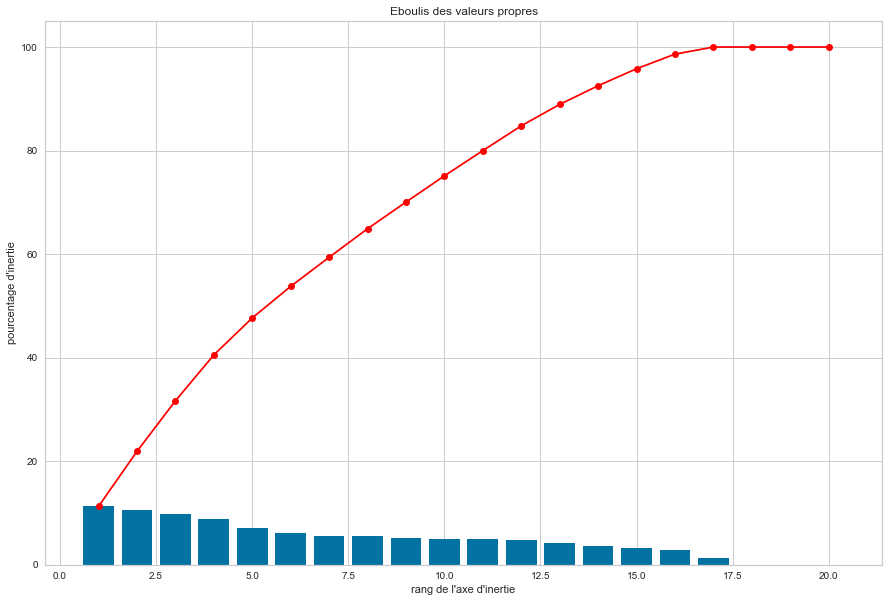

In [29]:
pca = decomposition.PCA(n_components=data_all.shape[1])
pca.fit(X)
X = pca.transform(X)

plt.figure(figsize=(15, 10))
display_scree_plot(pca)

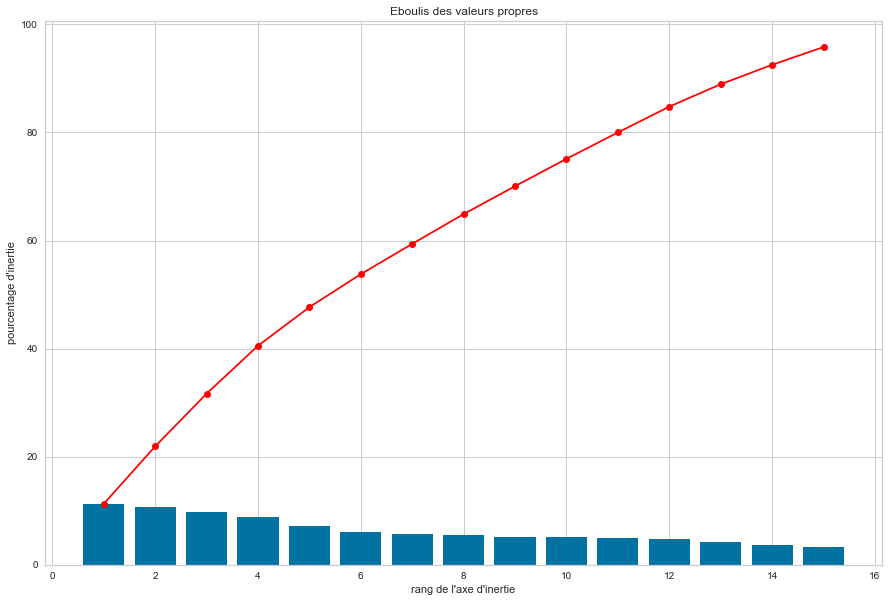

In [30]:
pca = decomposition.PCA(n_components=15)
pca.fit(X)
X = pca.transform(X)

plt.figure(figsize=(15, 10))
display_scree_plot(pca)

## Segmentation par kmeans avec optimisation du k <a class="anchor" id="chapter4"></a>

In [31]:
plt.rcParams["figure.figsize"] = (15, 10)

In [32]:
model = KMeans()

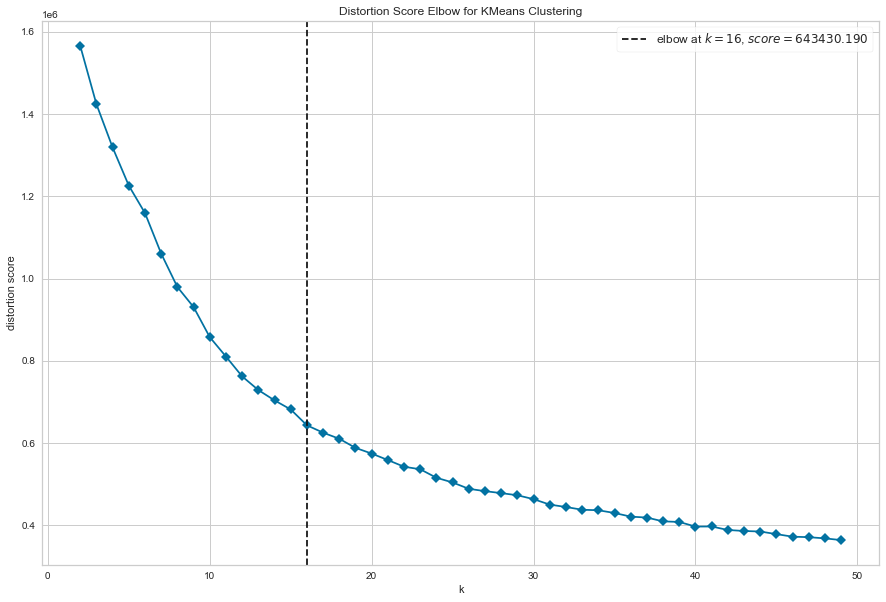

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
visualizer = KElbowVisualizer(model, k=(2, 50), metric="distortion", timings=False)

visualizer.fit(X)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the dat

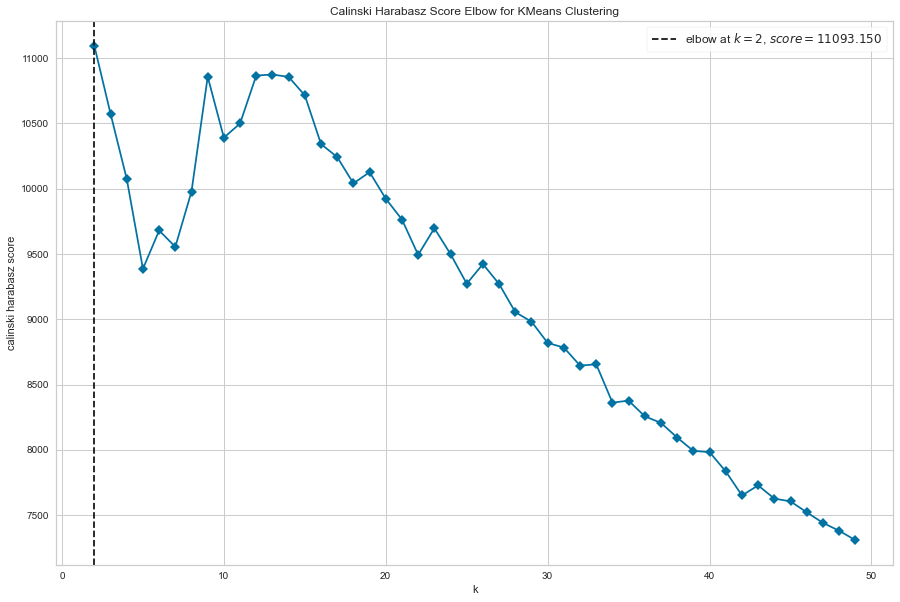

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [34]:
visualizer = KElbowVisualizer(
    model, k=(2, 50), metric="calinski_harabasz", timings=False
)

visualizer.fit(X)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the dat

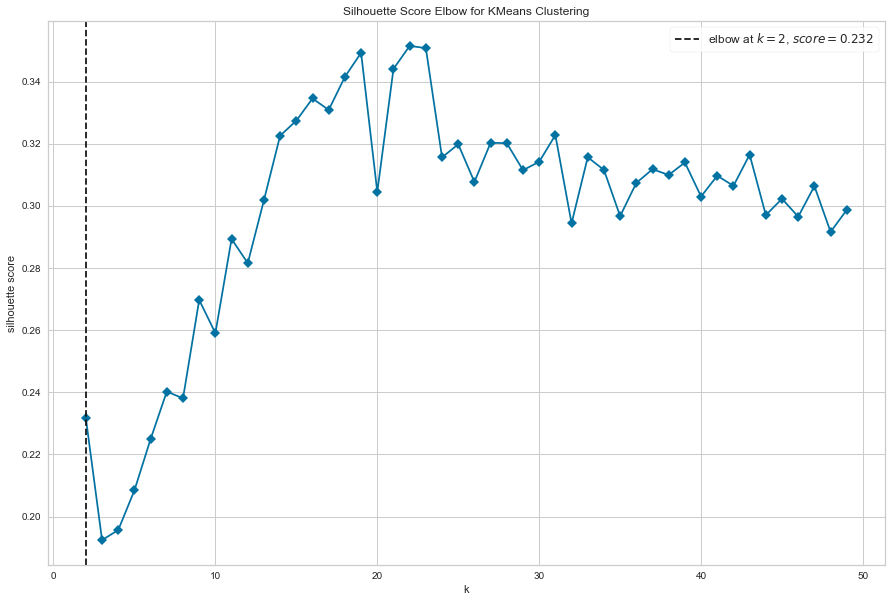

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [35]:
visualizer = KElbowVisualizer(model, k=(2, 50), metric="silhouette", timings=False)

visualizer.fit(X)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the dat

In [31]:
k_opt = round(statistics.mean([2, 2, 16]))
print(k_opt)

7


In [34]:
model = KMeans(n_clusters=k_opt)
kmeans = model.fit(X)

In [35]:
data["group"] = kmeans.labels_

In [36]:
data.head()

,nb_customer_id,nb_orders,mean_order_price,review_score_mean,freq_review_comment,freq_payment_type,payment_seq_mean,product_description_details_mean,order_item_id_mean,taux_livrs_mean,react_review_mean,shipping_day_nb_mean,freq_local_seller,group
customer_unique_id,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,1.0,129.90,5,Complet message,credit_card,8.0,141.60,1,9.0,1,5,Yes,4
0000b849f77a49e4a4ce2b2a4ca5be3f,1,1.0,18.90,4,No message,credit_card,1.0,355.60,1,44.0,1,4,Yes,2
0000f46a3911fa3c0805444483337064,1,1.0,69.00,3,No message,credit_card,8.0,260.19,1,25.0,1,5,No,0
0000f6ccb0745a6a4b88665a16c9f078,1,1.0,25.99,4,Message,credit_card,4.0,3743.15,1,68.0,1,6,No,1
0004aac84e0df4da2b147fca70cf8255,1,1.0,180.00,5,No message,credit_card,6.0,1381.56,1,9.0,1,8,Yes,2


In [37]:
data["group"] = data["group"].astype(int)

In [38]:
count(data["group"])

Counter({4: 8727, 2: 22125, 0: 25370, 1: 13953, 5: 16142, 6: 3493, 3: 1682})

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91492 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nb_customer_id                    91492 non-null  int64  
 1   nb_orders                         91492 non-null  float64
 2   mean_order_price                  91492 non-null  float64
 3   review_score_mean                 91492 non-null  int32  
 4   freq_review_comment               91492 non-null  object 
 5   freq_payment_type                 91492 non-null  object 
 6   payment_seq_mean                  91492 non-null  float64
 7   product_description_details_mean  91492 non-null  float64
 8   order_item_id_mean                91492 non-null  int32  
 9   taux_livrs_mean                   91492 non-null  float64
 10  react_review_mean                 91492 non-null  int32  
 11  shipping_day_n

## Statistiques descriptives des groupes issus de la segmentation par kmeans <a class="anchor" id="chapter5"></a>

### Effectifs <a class="anchor" id="section_5_1"></a>

C:\Users\n_a_e\anaconda3\envs\IML-P4\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Représentation graphique des effectifs par groupe'),
 Text(0.5, 0, 'groupes issus de la segmentation'),
 Text(0, 0.5, 'effectifs')]

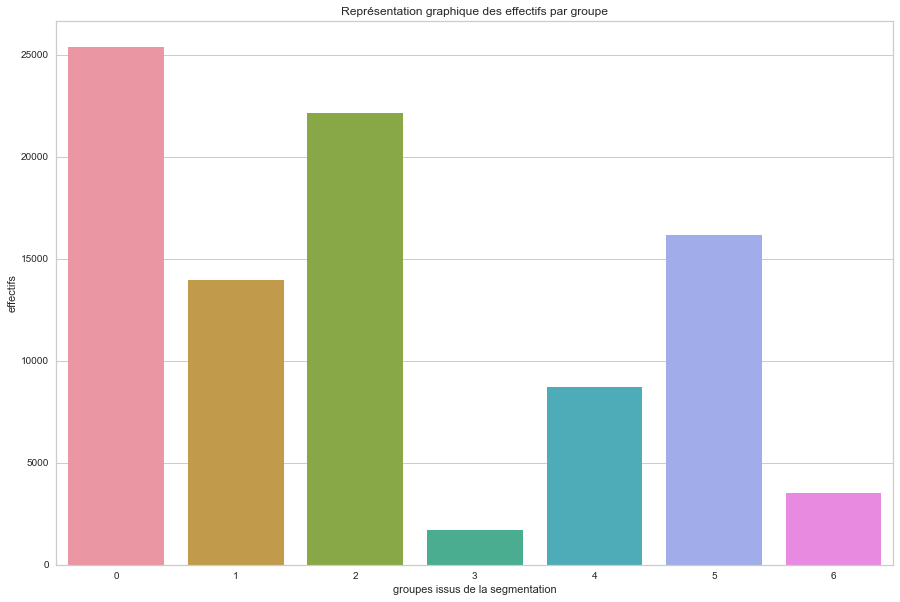

In [40]:
fig = sns.countplot(data["group"])
fig.set(
    title="Représentation graphique des effectifs par groupe",
    xlabel="groupes issus de la segmentation",
    ylabel="effectifs",
)

In [41]:
count(data["group"])

Counter({4: 8727, 2: 22125, 0: 25370, 1: 13953, 5: 16142, 6: 3493, 3: 1682})

### Nombre de comptes clients <a class="anchor" id="section_5_2"></a>

In [42]:
compte_moyen = statistics.mean(data["nb_customer_id"])
print(compte_moyen)

1.03616709657675


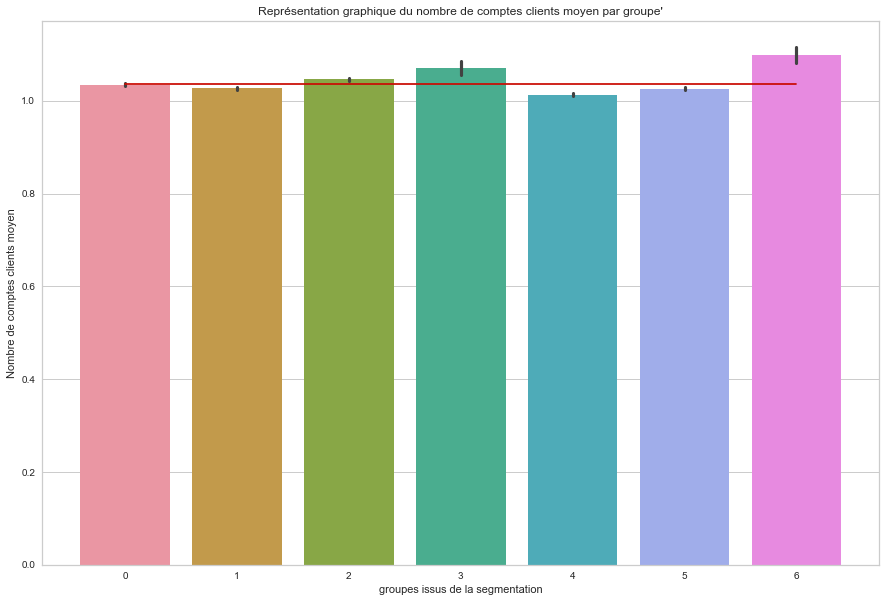

In [43]:
fig = sns.barplot(x=data["group"], y=data["nb_customer_id"])
fig.set(
    title="Représentation graphique du nombre de comptes clients moyen par groupe'",
    xlabel="groupes issus de la segmentation",
    ylabel="Nombre de comptes clients moyen",
)
plt.plot(np.linspace(0, 6, 6), [compte_moyen] * 6, "r-")

In [44]:
nb_customer_id_g = data.groupby("group").agg(
    nb_customer_id_g=("nb_customer_id", "mean")
)

In [45]:
nb_customer_id_g["ratio_nb_customer_id_g"] = nb_customer_id_g.apply(
    lambda r: round(r["nb_customer_id_g"] / compte_moyen, 2), axis=1
)

In [46]:
nb_customer_id_g

,nb_customer_id_g,ratio_nb_customer_id_g
group,,
0,1.034963,1.00
1,1.027378,0.99
2,1.046780,1.01
3,1.070155,1.03
4,1.013636,0.98
5,1.026329,0.99
6,1.098196,1.06


In [47]:
data["nb_customer_id"] = data["nb_customer_id"].astype(str)

In [48]:
var = "nb_customer_id"

In [49]:
data_var0 = data[var][data["group"] == 0]
data_var1 = data[var][data["group"] == 1]
data_var2 = data[var][data["group"] == 2]
data_var3 = data[var][data["group"] == 3]
data_var4 = data[var][data["group"] == 4]
data_var5 = data[var][data["group"] == 5]
data_var6 = data[var][data["group"] == 6]

<AxesSubplot:ylabel='nb_customer_id'>

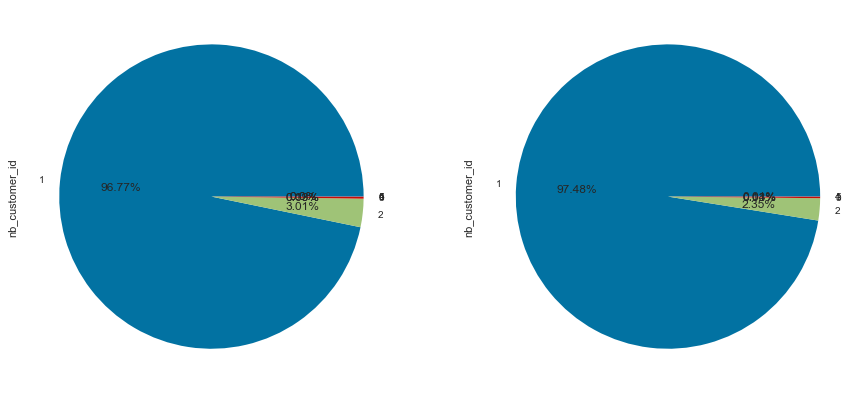

In [50]:
# Exploration des priofils de répartition pour les groupes 0 et 1

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var0.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

plt.subplot(1, 2, 2)
data_var1.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

<AxesSubplot:ylabel='nb_customer_id'>

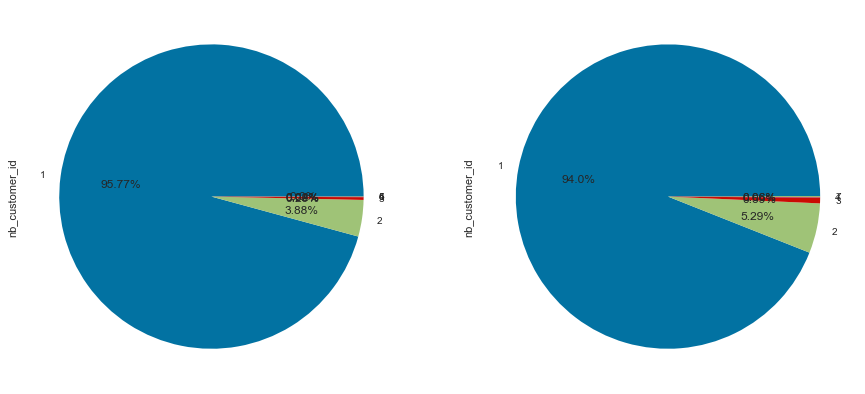

In [51]:
# Exploration des profils de répartition pour les groupes 2 et 3

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var2.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

plt.subplot(1, 2, 2)
data_var3.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

<AxesSubplot:ylabel='nb_customer_id'>

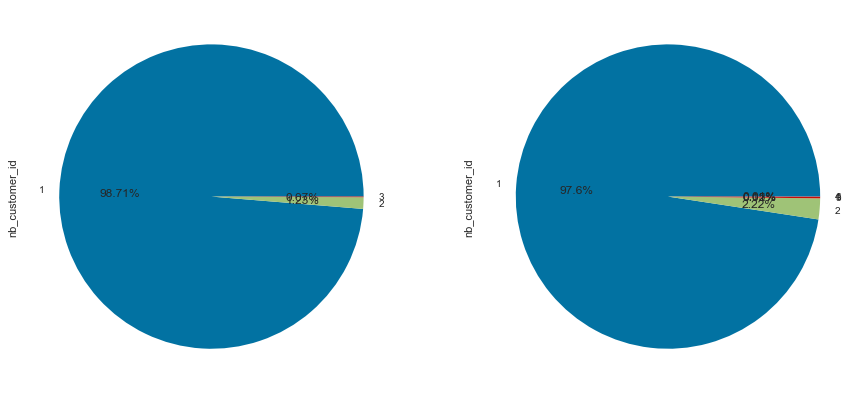

In [52]:
# Exploration des priofils de répartition pour les groupes 4 et 5

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var4.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

plt.subplot(1, 2, 2)
data_var5.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

<AxesSubplot:ylabel='nb_customer_id'>

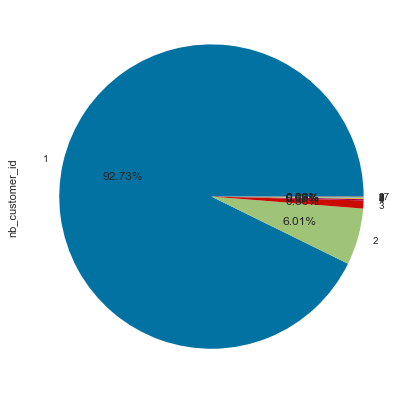

In [53]:
# Exploration des profils de répartition pour le groupe 6

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var6.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

In [54]:
data["nb_customer_id"] = data["nb_customer_id"].astype(int)

### Nombre de commande <a class="anchor" id="section_5_3"></a>

In [55]:
commande_moyen = statistics.mean(data["nb_orders"])
print(commande_moyen)

1.2375398941984


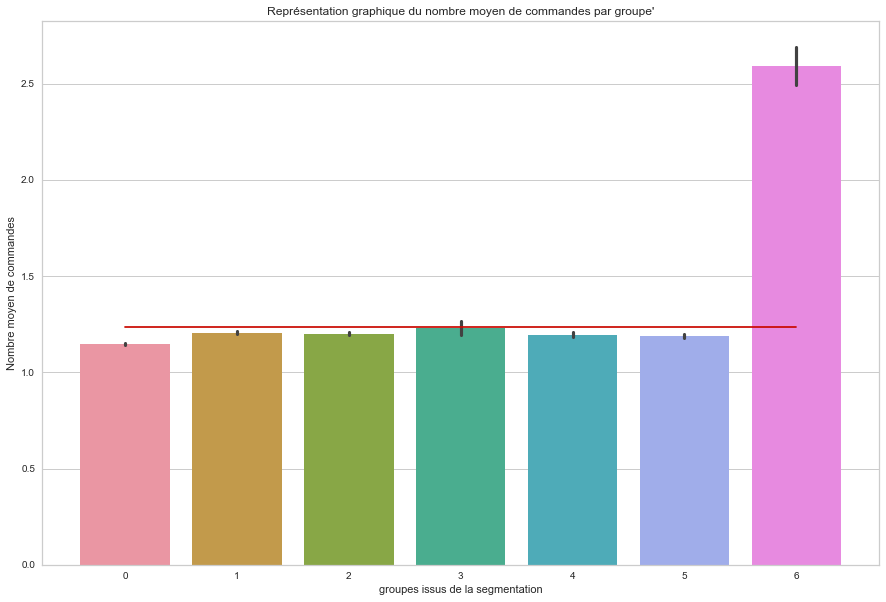

In [56]:
fig = sns.barplot(x=data["group"], y=data["nb_orders"])
fig.set(
    title="Représentation graphique du nombre moyen de commandes par groupe'",
    xlabel="groupes issus de la segmentation",
    ylabel="Nombre moyen de commandes",
)
plt.plot(np.linspace(0, 6, 6), [commande_moyen] * 6, "r-")

In [57]:
nb_orders_g = data.groupby("group").agg(nb_orders_g=("nb_orders", "mean"))

In [58]:
nb_orders_g["ratio_nb_orders_g"] = nb_orders_g.apply(
    lambda r: round(r["nb_orders_g"] / commande_moyen, 2), axis=1
)

In [59]:
nb_orders_g

,nb_orders_g,ratio_nb_orders_g
group,,
0,1.147576,0.93
1,1.206694,0.98
2,1.200136,0.97
3,1.227705,0.99
4,1.194569,0.97
5,1.188205,0.96
6,2.591182,2.09


### Montant du panier moyen <a class="anchor" id="section_5_4"></a>

In [60]:
panier_moyen = statistics.mean(data["mean_order_price"])
print(panier_moyen)

137.52086197531045


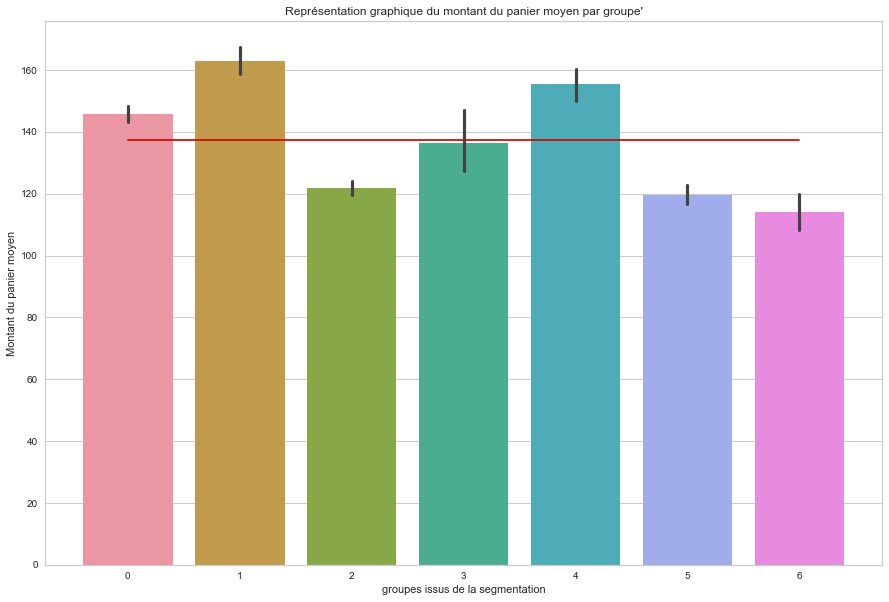

In [61]:
fig = sns.barplot(x=data["group"], y=data["mean_order_price"])
fig.set(
    title="Représentation graphique du montant du panier moyen par groupe'",
    xlabel="groupes issus de la segmentation",
    ylabel="Montant du panier moyen",
)
plt.plot(np.linspace(0, 6, 6), [panier_moyen] * 6, "r-")

In [62]:
order_price_g = data.groupby("group").agg(order_price_g=("mean_order_price", "mean"))

In [63]:
order_price_g["ratio_order_price_g"] = order_price_g.apply(
    lambda r: round(r["order_price_g"] / panier_moyen, 2), axis=1
)

In [64]:
order_price_g

,order_price_g,ratio_order_price_g
group,,
0,145.619274,1.06
1,163.053559,1.19
2,121.863812,0.89
3,136.453884,0.99
4,155.590036,1.13
5,119.617238,0.87
6,113.988960,0.83


### Note moyenne attribuée par les clients <a class="anchor" id="section_5_5"></a>

In [65]:
note_moyenne = statistics.mean(data["review_score_mean"])
print(note_moyenne)

4.150526822017225


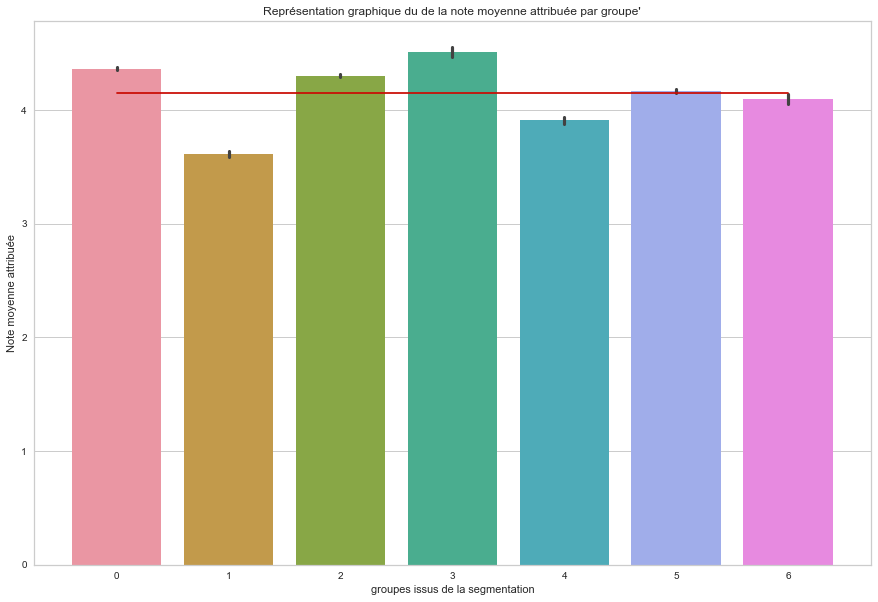

In [66]:
fig = sns.barplot(x=data["group"], y=data["review_score_mean"])
fig.set(
    title="Représentation graphique du de la note moyenne attribuée par groupe'",
    xlabel="groupes issus de la segmentation",
    ylabel="Note moyenne attribuée",
)
plt.plot(np.linspace(0, 6, 6), [note_moyenne] * 6, "r-")

In [67]:
review_score_g = data.groupby("group").agg(review_score_g=("review_score_mean", "mean"))

In [68]:
review_score_g["ratio_review_score_g"] = review_score_g.apply(
    lambda r: round(r["review_score_g"] / note_moyenne, 2), axis=1
)

In [69]:
review_score_g

,review_score_g,ratio_review_score_g
group,,
0,4.366614,1.05
1,3.613775,0.87
2,4.302915,1.04
3,4.512485,1.09
4,3.910164,0.94
5,4.170053,1.00
6,4.095906,0.99


### Morphologie de commentaire la plus fréquemment laissée <a class="anchor" id="section_5_6"></a>

In [70]:
var = "freq_review_comment"

In [71]:
data_var0 = data[var][data["group"] == 0]
data_var1 = data[var][data["group"] == 1]
data_var2 = data[var][data["group"] == 2]
data_var3 = data[var][data["group"] == 3]
data_var4 = data[var][data["group"] == 4]
data_var5 = data[var][data["group"] == 5]
data_var6 = data[var][data["group"] == 6]

<AxesSubplot:ylabel='freq_review_comment'>

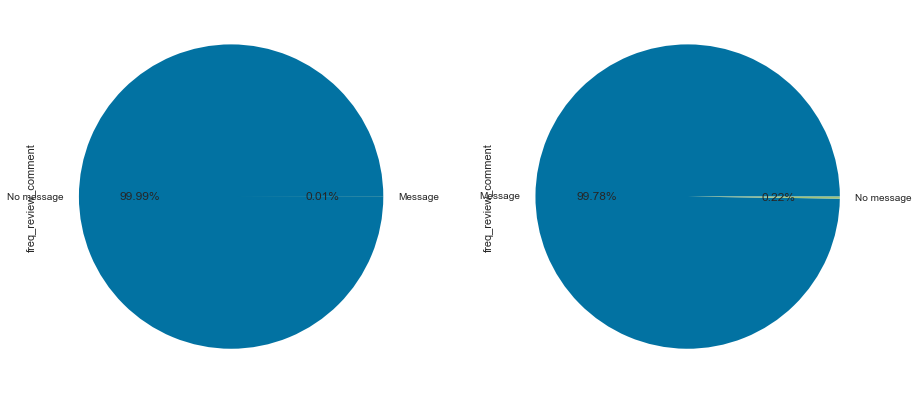

In [72]:
# Exploration des profils de répartition pour les groupes 0 et 1

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var0.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

plt.subplot(1, 2, 2)
data_var1.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

<AxesSubplot:ylabel='freq_review_comment'>

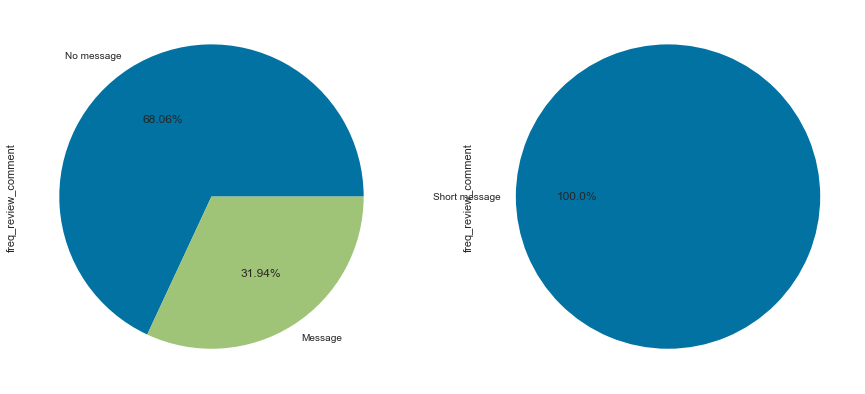

In [73]:
# Exploration des profils de répartition pour les groupes 2 et 3

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var2.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

plt.subplot(1, 2, 2)
data_var3.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

<AxesSubplot:ylabel='freq_review_comment'>

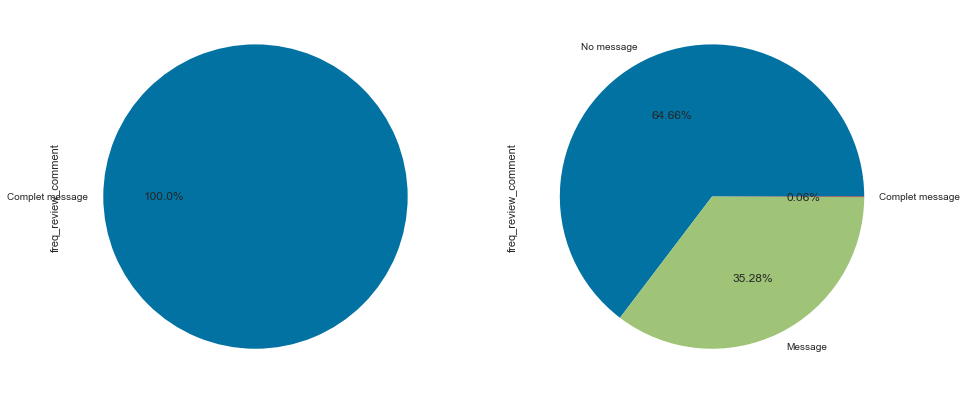

In [74]:
# Exploration des priofils de répartition pour les groupes 4 et 5

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var4.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

plt.subplot(1, 2, 2)
data_var5.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

<AxesSubplot:ylabel='freq_review_comment'>

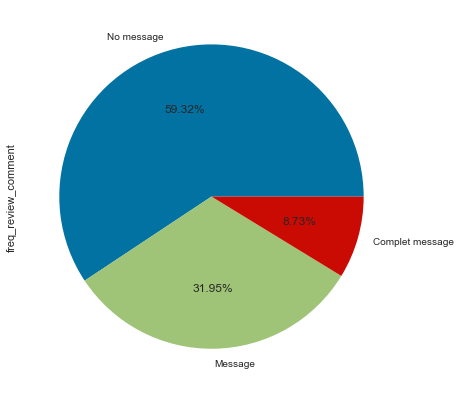

In [75]:
# Exploration des profils de répartition pour le groupe 6

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var6.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

### Moyen de paiement le plus fréquent <a class="anchor" id="section_5_7"></a>

In [76]:
var = "freq_payment_type"

In [77]:
data_var0 = data[var][data["group"] == 0]
data_var1 = data[var][data["group"] == 1]
data_var2 = data[var][data["group"] == 2]
data_var3 = data[var][data["group"] == 3]
data_var4 = data[var][data["group"] == 4]
data_var5 = data[var][data["group"] == 5]
data_var6 = data[var][data["group"] == 6]

<AxesSubplot:ylabel='freq_payment_type'>

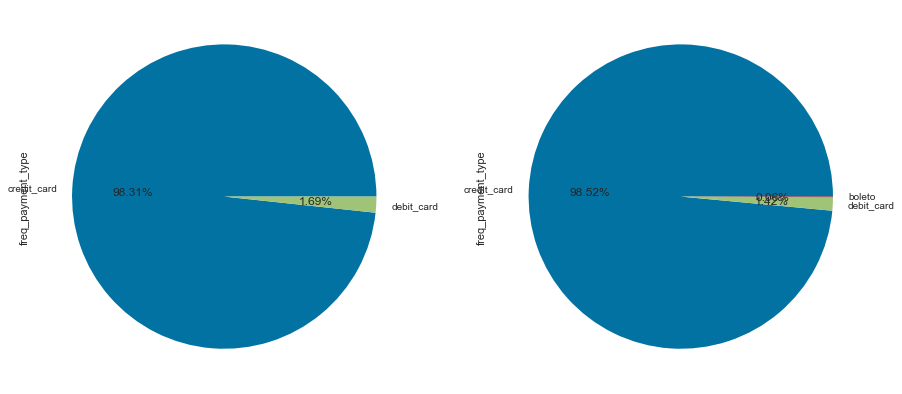

In [78]:
# Exploration des profils de répartition pour les groupes 0 et 1

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var0.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

plt.subplot(1, 2, 2)
data_var1.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

<AxesSubplot:ylabel='freq_payment_type'>

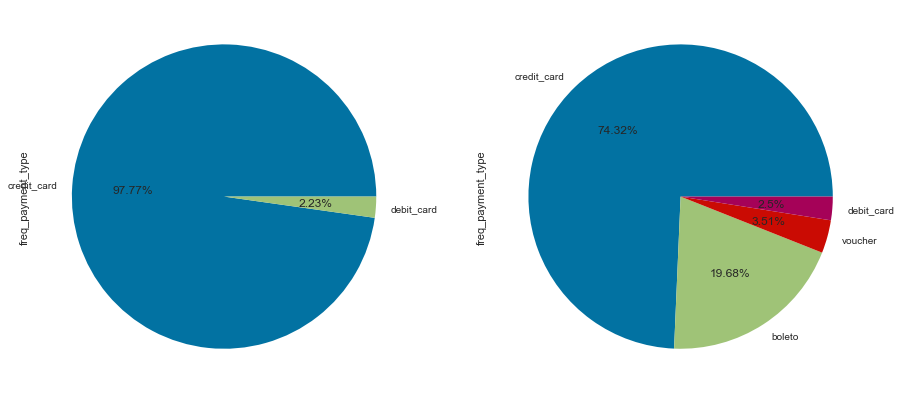

In [79]:
# Exploration des priofils de répartition pour les groupes 2 et 3

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var2.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

plt.subplot(1, 2, 2)
data_var3.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

<AxesSubplot:ylabel='freq_payment_type'>

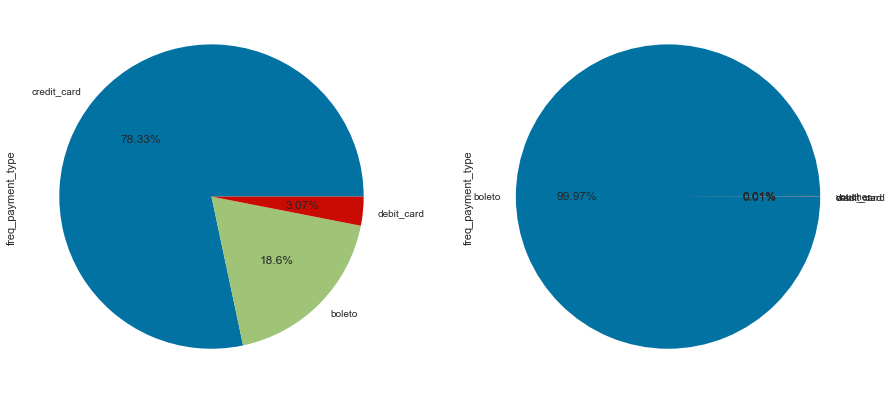

In [80]:
# Exploration des priofils de répartition pour les groupes 4 et 5

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var4.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

plt.subplot(1, 2, 2)
data_var5.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

<AxesSubplot:ylabel='freq_payment_type'>

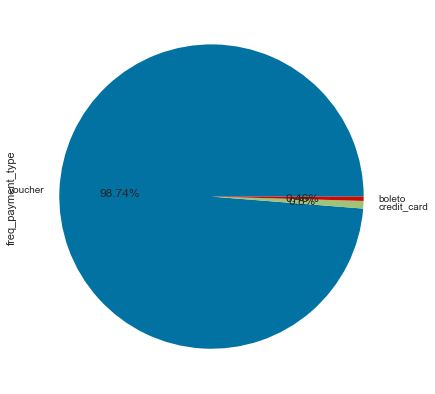

In [81]:
# Exploration des priofils de répartition pour les groupes 6

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var6.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

### Comportement de paiement <a class="anchor" id="section_5_8"></a> 

In [82]:
payment_seq_moyen = statistics.mean(data["payment_seq_mean"])
print(payment_seq_moyen)

2.970932017560302


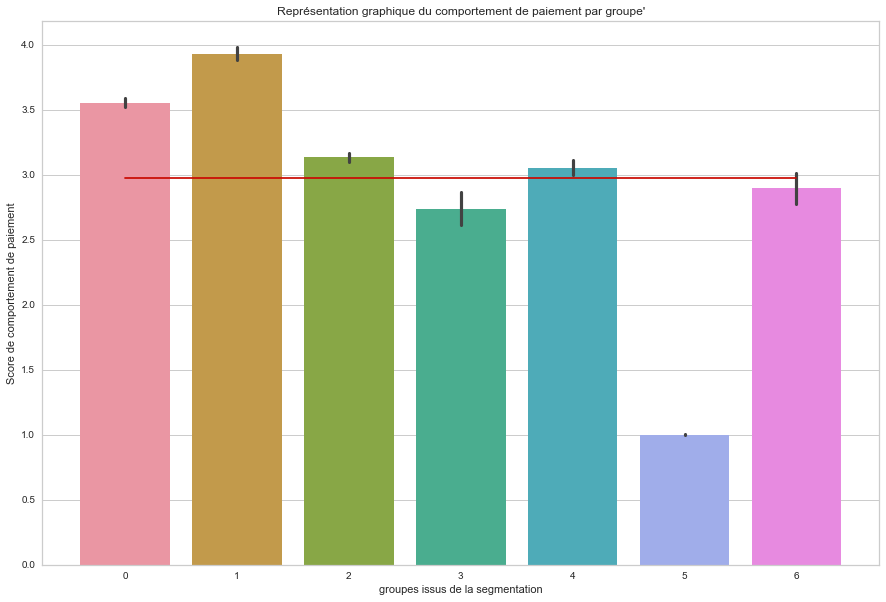

In [83]:
fig = sns.barplot(x=data["group"], y=data["payment_seq_mean"])
fig.set(
    title="Représentation graphique du comportement de paiement par groupe'",
    xlabel="groupes issus de la segmentation",
    ylabel="Score de comportement de paiement",
)
plt.plot(np.linspace(0, 6, 6), [payment_seq_moyen] * 6, "r-")

In [84]:
payment_seq_mean_g = data.groupby("group").agg(
    payment_seq_mean_g=("payment_seq_mean", "mean")
)

In [85]:
payment_seq_mean_g["ratio_payment_seq_mean_g"] = payment_seq_mean_g.apply(
    lambda r: round(r["payment_seq_mean_g"] / payment_seq_moyen, 2), axis=1
)

In [86]:
payment_seq_mean_g

,payment_seq_mean_g,ratio_payment_seq_mean_g
group,,
0,3.553418,1.20
1,3.930390,1.32
2,3.132311,1.05
3,2.738722,0.92
4,3.052859,1.03
5,1.000712,0.34
6,2.897467,0.98


### Impact du degrès de détail des annonces produits dans l'intention d'achat <a class="anchor" id="section_5_9"></a> 

In [87]:
prod_det_moyen = statistics.mean(data["product_description_details_mean"])
print(prod_det_moyen)

985.5007930382923


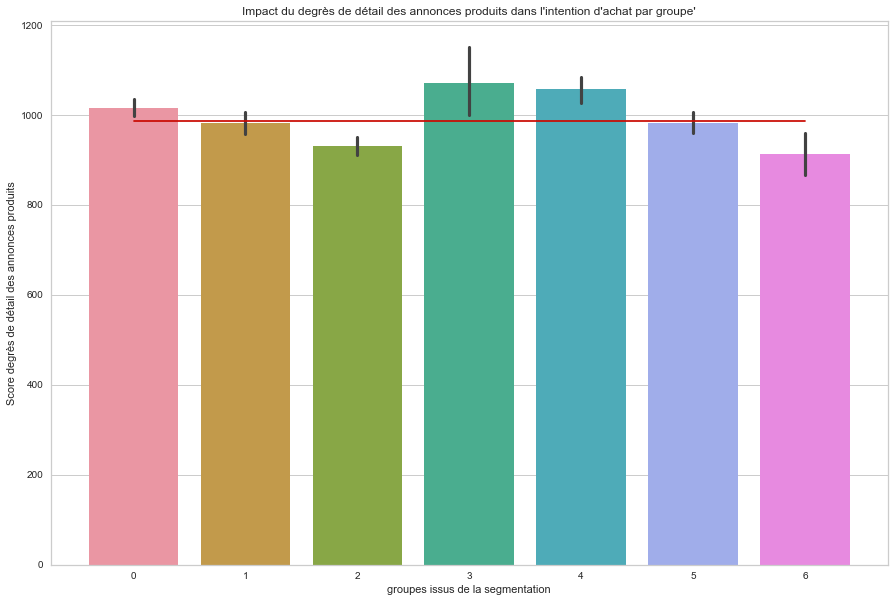

In [88]:
fig = sns.barplot(x=data["group"], y=data["product_description_details_mean"])
fig.set(
    title="Impact du degrès de détail des annonces produits dans l'intention d'achat par groupe'",
    xlabel="groupes issus de la segmentation",
    ylabel="Score degrès de détail des annonces produits",
)
plt.plot(np.linspace(0, 6, 6), [prod_det_moyen] * 6, "r-")

In [89]:
description_details = data.groupby("group").agg(
    description_details=("product_description_details_mean", "mean")
)

In [90]:
description_details["ratio_description_details"] = description_details.apply(
    lambda r: round(r["description_details"] / prod_det_moyen, 2), axis=1
)

In [91]:
description_details

,description_details,ratio_description_details
group,,
0,1016.492903,1.03
1,981.860540,1.00
2,931.091963,0.94
3,1071.200829,1.09
4,1056.555688,1.07
5,983.016079,1.00
6,912.263665,0.93


### Nombre moyen d'objets par commande <a class="anchor" id="section_5_10"></a>

In [92]:
order_it_moyen = statistics.mean(data["order_item_id_mean"])
print(order_it_moyen)

1.0280570978883399


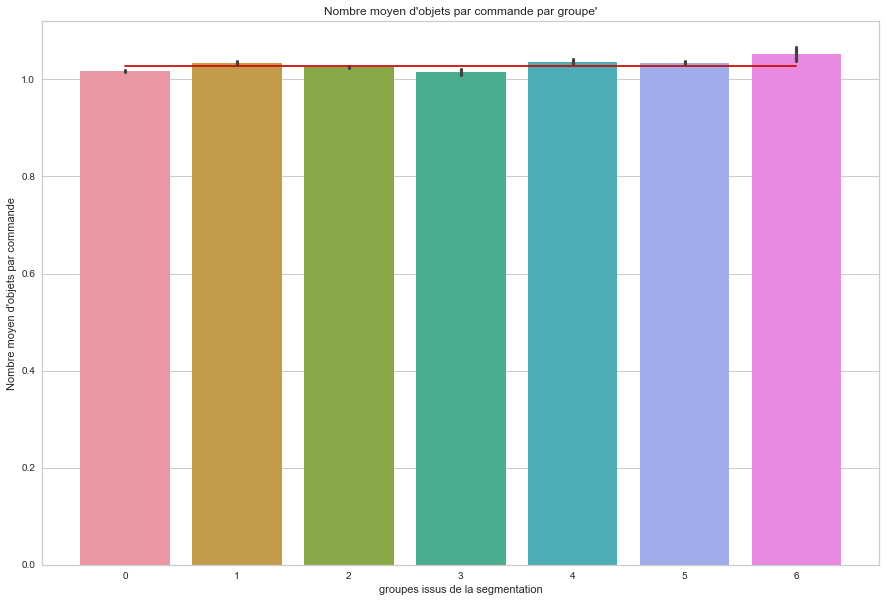

In [93]:
fig = sns.barplot(x=data["group"], y=data["order_item_id_mean"])
fig.set(
    title="Nombre moyen d'objets par commande par groupe'",
    xlabel="groupes issus de la segmentation",
    ylabel="Nombre moyen d'objets par commande",
)
plt.plot(np.linspace(0, 6, 6), [order_it_moyen] * 6, "r-")

In [94]:
order_item_id_mean_g = data.groupby("group").agg(
    order_item_id_mean_g=("order_item_id_mean", "mean")
)

In [95]:
order_item_id_mean_g["ratio_order_item_id_mean_g"] = order_item_id_mean_g.apply(
    lambda r: round(r["order_item_id_mean_g"] / order_it_moyen, 2), axis=1
)

In [96]:
order_item_id_mean_g

,order_item_id_mean_g,ratio_order_item_id_mean_g
group,,
0,1.017501,0.99
1,1.033183,1.00
2,1.026079,1.00
3,1.014863,0.99
4,1.036782,1.01
5,1.034506,1.01
6,1.051532,1.02


In [97]:
data["order_item_id_mean"].describe()

count    91492.000000
mean         1.028057
std          0.209015
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         11.000000
Name: order_item_id_mean, dtype: float64

In [98]:
data["order_item_id_mean"] = data["order_item_id_mean"].astype(str)

In [99]:
var = "order_item_id_mean"

In [100]:
data_var0 = data[var][data["group"] == 0]
data_var1 = data[var][data["group"] == 1]
data_var2 = data[var][data["group"] == 2]
data_var3 = data[var][data["group"] == 3]
data_var4 = data[var][data["group"] == 4]
data_var5 = data[var][data["group"] == 5]
data_var6 = data[var][data["group"] == 6]

<AxesSubplot:ylabel='order_item_id_mean'>

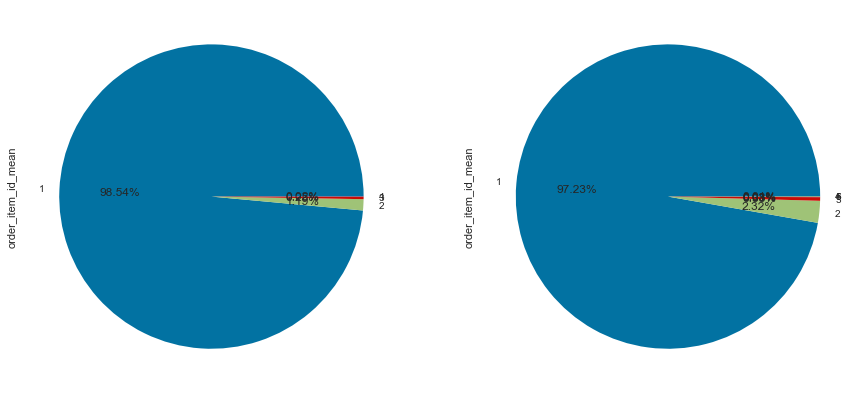

In [101]:
# Exploration des profils de répartition pour les groupes 0 et 1

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var0.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

plt.subplot(1, 2, 2)
data_var1.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

<AxesSubplot:ylabel='order_item_id_mean'>

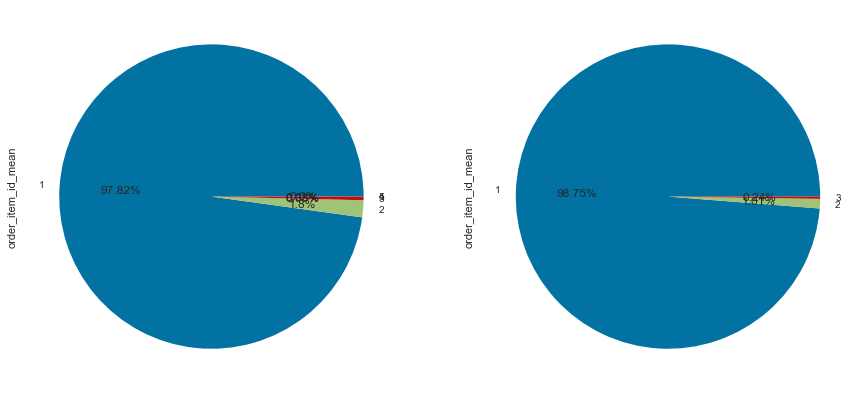

In [102]:
# Exploration des priofils de répartition pour les groupes 2 et 3

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var2.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

plt.subplot(1, 2, 2)
data_var3.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

<AxesSubplot:ylabel='order_item_id_mean'>

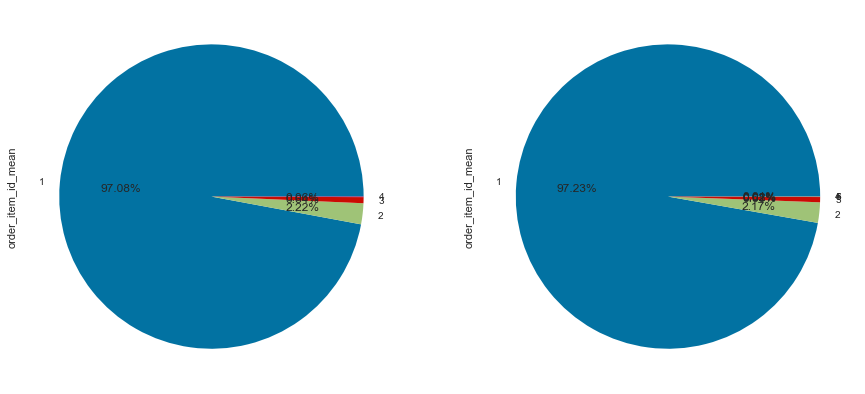

In [103]:
# Exploration des priofils de répartition pour les groupes 4 et 5

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var4.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

plt.subplot(1, 2, 2)
data_var5.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

<AxesSubplot:ylabel='order_item_id_mean'>

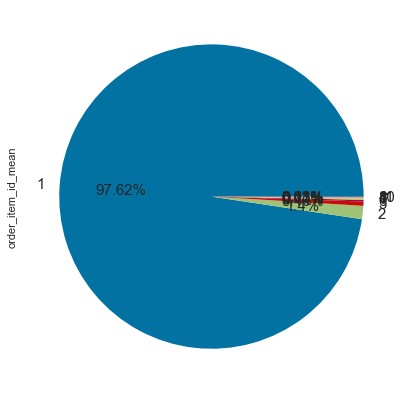

In [119]:
# Exploration des priofils de répartition pour les groupes 6

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var6.value_counts(normalize=True).plot(
    kind="pie",
    autopct=lambda x: str(round(x, 2)) + "%",
    fontsize=15,
)

In [121]:
count(data_var6)

Counter({'1': 3410,
         '2': 49,
         '3': 16,
         '7': 4,
         '8': 1,
         '6': 6,
         '4': 1,
         '11': 1,
         '10': 1,
         '5': 4})

### Impact des frais de livraison dans l'acte d'achat <a class="anchor" id="section_5_11"></a>

In [105]:
livr_moyen = statistics.mean(data["taux_livrs_mean"])
print(livr_moyen)

30.890630389972465


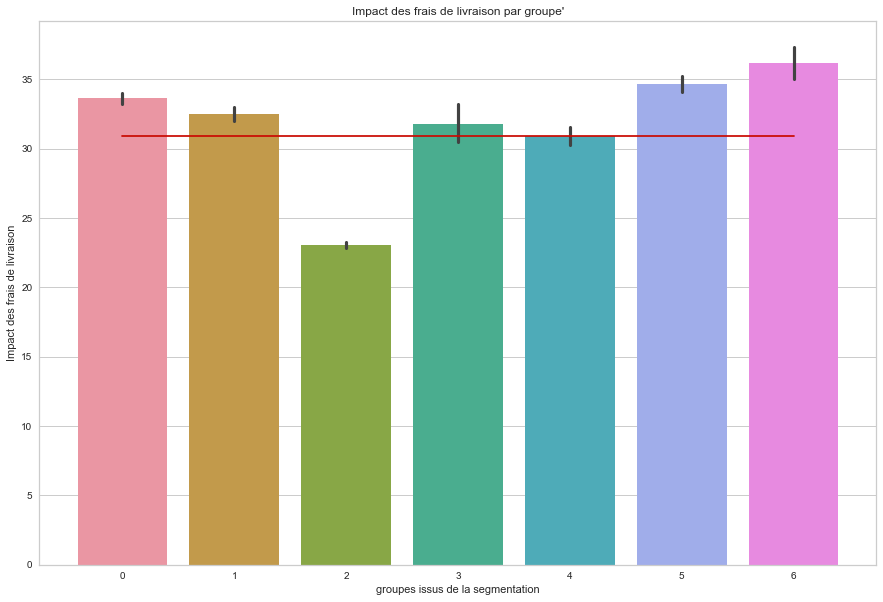

In [106]:
fig = sns.barplot(x=data["group"], y=data["taux_livrs_mean"])
fig.set(
    title="Impact des frais de livraison par groupe'",
    xlabel="groupes issus de la segmentation",
    ylabel="Impact des frais de livraison",
)
plt.plot(np.linspace(0, 6, 6), [livr_moyen] * 6, "r-")

In [107]:
taux_livrs_mean_g = data.groupby("group").agg(
    taux_livrs_mean_g=("taux_livrs_mean", "mean")
)

In [108]:
taux_livrs_mean_g["ratio_taux_livrs_mean_g"] = taux_livrs_mean_g.apply(
    lambda r: round(r["taux_livrs_mean_g"] / livr_moyen, 2), axis=1
)

In [109]:
taux_livrs_mean_g

,taux_livrs_mean_g,ratio_taux_livrs_mean_g
group,,
0,33.627380,1.09
1,32.509023,1.05
2,23.052583,0.75
3,31.812523,1.03
4,30.942955,1.00
5,34.661727,1.12
6,36.193735,1.17


### Réactivité commentaire <a class="anchor" id="section_5_12"></a>

In [110]:
react_moyen = statistics.mean(data["react_review_mean"])
print(react_moyen)

0.452432999606523


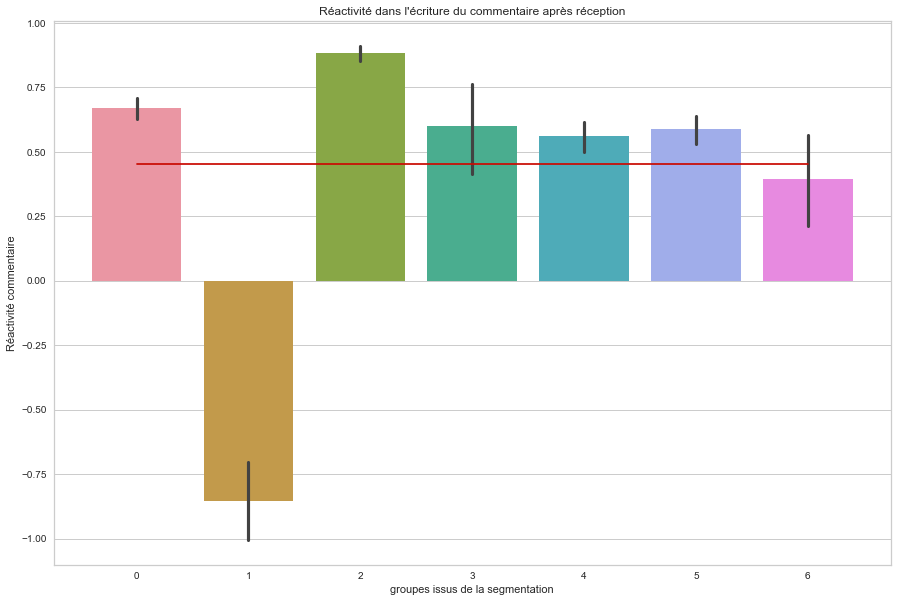

In [122]:
fig = sns.barplot(x=data["group"], y=data["react_review_mean"])
fig.set(
    title="Réactivité dans l'écriture du commentaire après réception",
    xlabel="groupes issus de la segmentation",
    ylabel="Réactivité commentaire",
)
plt.plot(np.linspace(0, 6, 6), [react_moyen] * 6, "r-")

In [123]:
react_review_mean_g = data.groupby("group").agg(
    react_review_mean_g=("react_review_mean", "mean")
)

In [124]:
order_item_id_mean_g["ratio_order_item_id_mean_g"] = order_item_id_mean_g.apply(
    lambda r: round(r["order_item_id_mean_g"] / react_moyen, 2), axis=1
)

In [125]:
order_item_id_mean_g

,order_item_id_mean_g,ratio_order_item_id_mean_g
group,,
0,1.017501,2.25
1,1.033183,2.28
2,1.026079,2.27
3,1.014863,2.24
4,1.036782,2.29
5,1.034506,2.29
6,1.051532,2.32


### Délais de livraison acceptable <a class="anchor" id="section_5_13"></a>

In [126]:
shipp_moyen = statistics.mean(data["shipping_day_nb_mean"])
print(shipp_moyen)

6.629311852402396


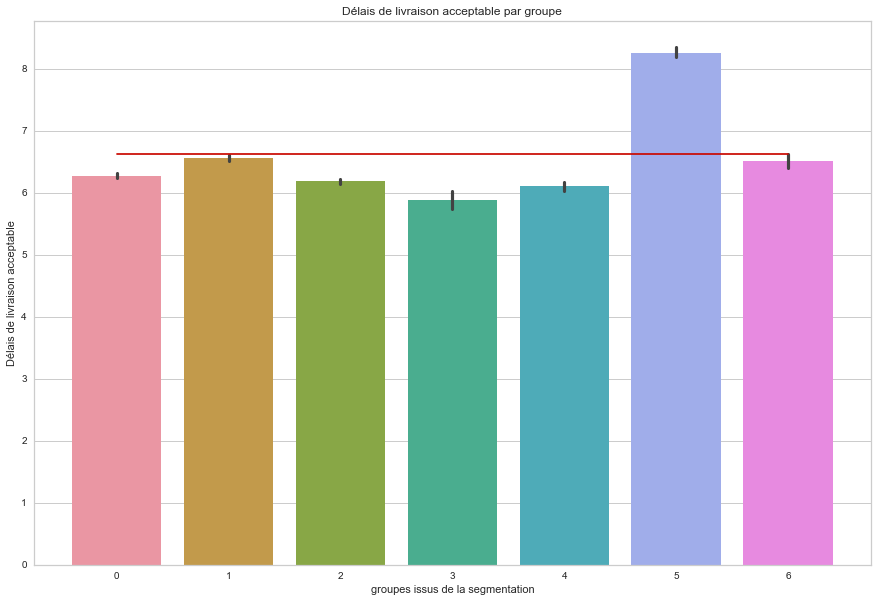

In [127]:
fig = sns.barplot(x=data["group"], y=data["shipping_day_nb_mean"])
fig.set(
    title="Délais de livraison acceptable par groupe",
    xlabel="groupes issus de la segmentation",
    ylabel="Délais de livraison acceptable",
)
plt.plot(np.linspace(0, 6, 6), [shipp_moyen] * 6, "r-")

### Achat local <a class="anchor" id="section_5_14"></a>

In [128]:
var = "freq_local_seller"

In [129]:
data_var0 = data[var][data["group"] == 0]
data_var1 = data[var][data["group"] == 1]
data_var2 = data[var][data["group"] == 2]
data_var3 = data[var][data["group"] == 3]
data_var4 = data[var][data["group"] == 4]
data_var5 = data[var][data["group"] == 5]
data_var6 = data[var][data["group"] == 6]

<AxesSubplot:ylabel='freq_local_seller'>

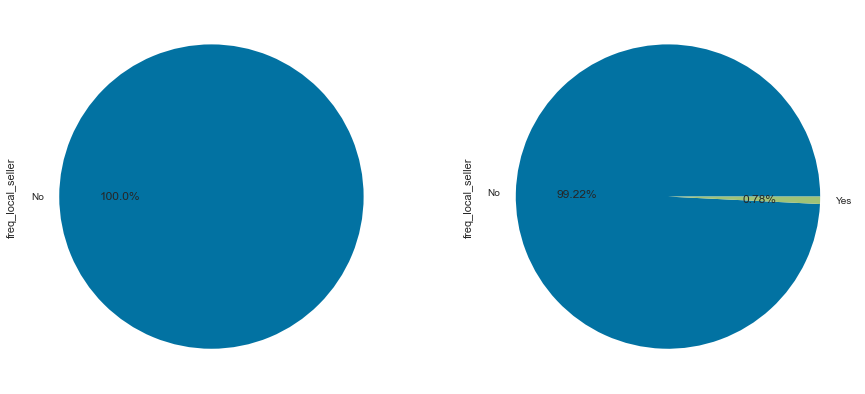

In [130]:
# Exploration des profils de répartition pour les groupes 0 et 1

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var0.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

plt.subplot(1, 2, 2)
data_var1.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

<AxesSubplot:ylabel='freq_local_seller'>

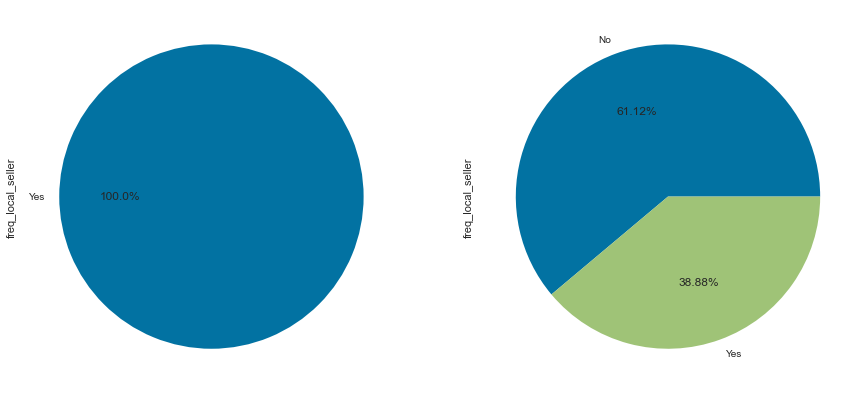

In [131]:
# Exploration des priofils de répartition pour les groupes 2 et 3

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var2.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

plt.subplot(1, 2, 2)
data_var3.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

<AxesSubplot:ylabel='freq_local_seller'>

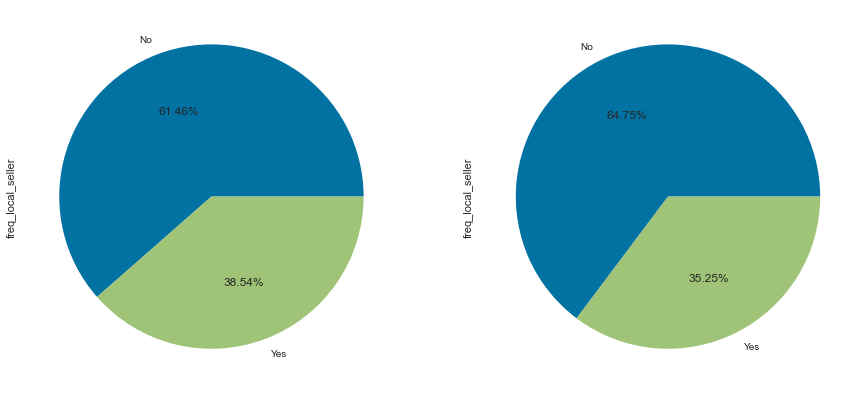

In [132]:
# Exploration des priofils de répartition pour les groupes 4 et 5

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var4.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

plt.subplot(1, 2, 2)
data_var5.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)

<AxesSubplot:ylabel='freq_local_seller'>

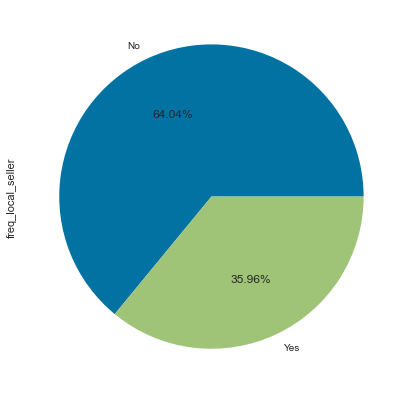

In [133]:
# Exploration des profils de répartition pour le groupes 6

fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
data_var6.value_counts(normalize=True).plot(
    kind="pie", autopct=lambda x: str(round(x, 2)) + "%"
)